## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

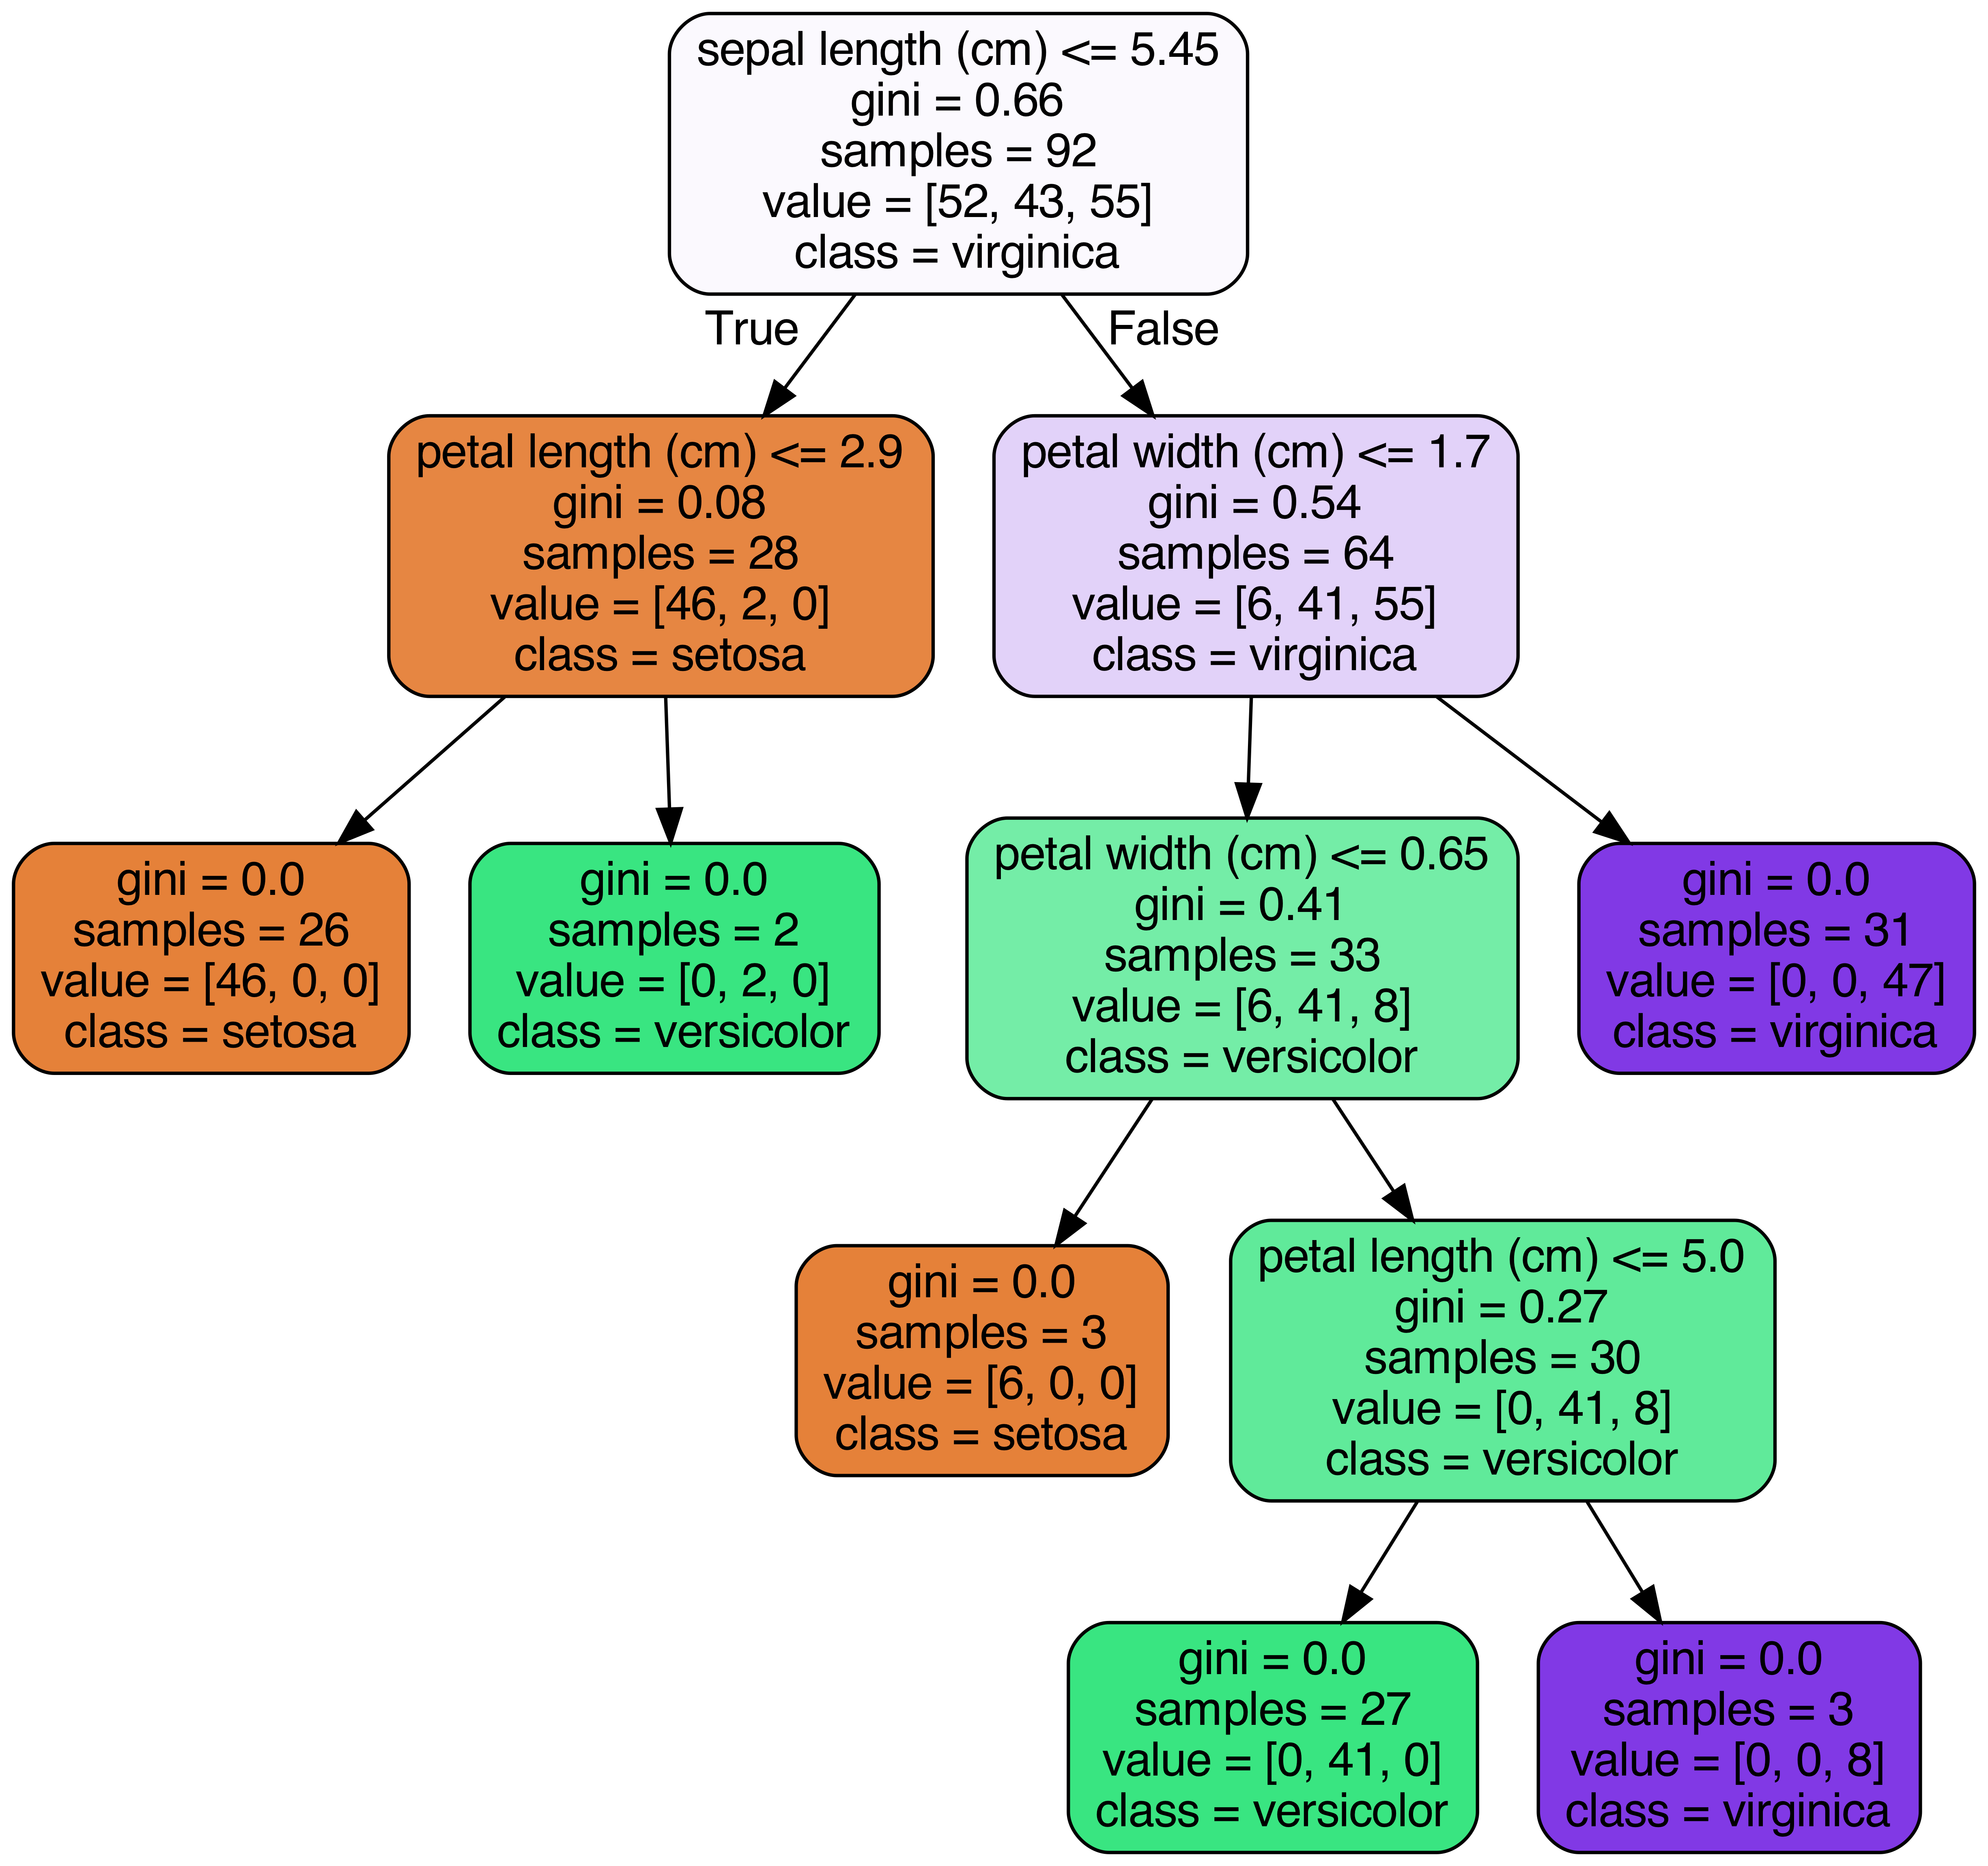

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [2]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from datetime import datetime, date

#import datetime as DT
#import io


In [3]:
url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [4]:
df.shape

(2218, 18)

In [5]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [6]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

df['current_year'] = date.today().year
#df.dtypes
df['birth_year'] = df['birth_year'].astype(int)
df['n_age'] = df['now'] - df['birth_year']

In [7]:
df['current_year'] = date.today().year
#df.dtypes

for row in df['current_year']:
    try:
        df['birth_year'] = df['birth_year'].astype(int)
    except:
        pass # doing nothing on exception

#df['n_age'] = 
for row in df['current_year']:
    try:
        df['n_age'] = df['current_year'] - df['birth_year']
    except:
        pass # doing nothing on exception

#df = df.drop('current_year', axis=1)

In [8]:
df.head(10)
#df.dtypes

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,current_year,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,2023,59.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released,2023,36.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,2023,59.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,2023,32.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,2023,31.0
5,1000000006,10.0,female,1966.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,3.0,1.000000e+09,43.0,NaN,2020-01-31,2020-02-19,NaN,released,2023,57.0
6,1000000007,11.0,male,1995.0,20s,Korea,Seoul,Jongno-gu,NaN,contact with patient,3.0,1.000000e+09,0.0,NaN,2020-01-31,2020-02-10,NaN,released,2023,28.0
7,1000000008,13.0,male,1992.0,20s,Korea,Seoul,etc,NaN,overseas inflow,1.0,NaN,0.0,NaN,2020-02-02,2020-02-24,NaN,released,2023,31.0
8,1000000009,19.0,male,1983.0,30s,Korea,Seoul,Songpa-gu,NaN,overseas inflow,2.0,NaN,68.0,NaN,2020-02-05,2020-02-21,NaN,released,2023,40.0
9,1000000010,21.0,female,1960.0,60s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,3.0,1.000000e+09,6.0,NaN,2020-02-05,2020-02-29,NaN,released,2023,63.0


### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [9]:
df.isna().sum()

patient_id               0
global_num             904
sex                    145
birth_year             454
age                    261
country                  0
province                 0
city                    65
disease               2199
infection_case        1055
infection_order       2176
infected_by           1749
contact_number        1807
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
current_year             0
n_age                  454
dtype: int64

In [10]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,n_age,454


 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [11]:
df['disease'].value_counts(dropna=False)

NaN     2199
True      19
Name: disease, dtype: int64

In [12]:
df['disease'] = df['disease'].replace(True, 1)
df['disease'] = df['disease'].replace(np.nan, 0)
df['disease'].value_counts(dropna=False)

0.0    2199
1.0      19
Name: disease, dtype: int64

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [13]:
column_list_mean = ['global_num','birth_year','infection_order','infected_by', 'contact_number']

In [14]:
for column_name in column_list_mean:
    df[column_name].fillna(int(df[column_name].mean()), inplace=True)


In [15]:
# now that we have a mean for birth_year, run this for loop again
for row in df['current_year']:
    try:
        df['n_age'] = df['current_year'] - df['birth_year']
    except:
        pass # doing nothing on exception

df = df.drop('current_year', axis=1)

In [16]:
df.isna().sum()

patient_id               0
global_num               0
sex                    145
birth_year               0
age                    261
country                  0
province                 0
city                    65
disease                  0
infection_case        1055
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                    0
dtype: int64

In [17]:
df.shape

(2218, 19)

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [18]:
df.isna().sum()

patient_id               0
global_num               0
sex                    145
birth_year               0
age                    261
country                  0
province                 0
city                    65
disease                  0
infection_case        1055
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                    0
dtype: int64

In [19]:
# delete rows missing city, since there are only 65 missing values
# delete rows missing sex, since there are only 145 missing values
df.dropna(subset=['city', 'sex'], inplace=True)

# there are 1055 missing values in infection case, so we don't want to throw those out.  Instead I'll replace that with "Unknown"
#df['infection_case'] = df['infection_case'].replace(np.nan, 'Unknown')
df['infection_case'] = df['infection_case'].replace(np.nan, 'Unknown')

# will also replace values in 'state' with 'unknown', since this is an important variable, and don't want to drop these values yet
#df['state'] = df['state'].replace(np.nan, 'Unknown')



In [20]:
#df.info()

In [21]:
df.isna().sum()

patient_id               0
global_num               0
sex                      0
birth_year               0
age                    118
country                  0
province                 0
city                     0
disease                  0
infection_case           0
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    1821
confirmed_date           1
released_date         1802
deceased_date         1998
state                   88
n_age                    0
dtype: int64

In [22]:
df.shape

(2011, 19)

age: ignore for now



In [23]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0.0,overseas inflow,1.0,2.600789e+09,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,59.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0.0,overseas inflow,1.0,2.600789e+09,31.0,NaN,2020-01-30,2020-03-02,NaN,released,36.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0.0,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,59.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0.0,overseas inflow,1.0,2.600789e+09,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,32.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0.0,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,31.0


In [24]:
df['state'].value_counts(dropna=False)

isolated    1618
released     293
NaN           88
deceased      12
Name: state, dtype: int64

 **<font color='teal'> Check for any remaining null values.</font>**

In [25]:
df.isna().sum()

patient_id               0
global_num               0
sex                      0
birth_year               0
age                    118
country                  0
province                 0
city                     0
disease                  0
infection_case           0
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    1821
confirmed_date           1
released_date         1802
deceased_date         1998
state                   88
n_age                    0
dtype: int64

Remove date columns from the data.


In [26]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

Drop patient_id and global_num as well, since I don't think these have any predictive meaning

In [27]:
df = df.drop(['patient_id','global_num'],axis =1)

Review the count of unique values by column.

In [28]:
print(df.nunique())

sex                  2
birth_year          96
age                 11
country              4
province            16
city               129
disease              2
infection_case      17
infection_order      6
infected_by        201
contact_number      64
state                3
n_age               96
dtype: int64


Review the percent of unique values by column.

In [29]:
print(df.nunique()/df.shape[0])

sex                0.000995
birth_year         0.047737
age                0.005470
country            0.001989
province           0.007956
city               0.064147
disease            0.000995
infection_case     0.008454
infection_order    0.002984
infected_by        0.099950
contact_number     0.031825
state              0.001492
n_age              0.047737
dtype: float64


Review the range of values per column.

In [30]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
birth_year,2011.0,1.975218e+03,1.784579e+01,1.916000e+03,1.964000e+03,1.974000e+03,1.990000e+03,2.020000e+03
disease,2011.0,4.972650e-03,7.035897e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infection_order,2011.0,2.005967e+00,1.838348e-01,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,6.000000e+00
infected_by,2011.0,2.612681e+09,7.472734e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2011.0,2.289010e+01,2.893091e+01,0.000000e+00,2.400000e+01,2.400000e+01,2.400000e+01,1.091000e+03
n_age,2011.0,4.778170e+01,1.784579e+01,3.000000e+00,3.300000e+01,4.900000e+01,5.900000e+01,1.070000e+02


### Check for duplicated rows

In [31]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age
11,male,1992.0,20s,Korea,Seoul,etc,0.0,overseas inflow,1.0,2.600789e+09,0.0,released,31.0
153,female,1969.0,50s,Korea,Seoul,Guro-gu,0.0,Guro-gu Call Center,2.0,2.600789e+09,24.0,isolated,54.0
161,female,1966.0,50s,Korea,Seoul,Gangseo-gu,0.0,Guro-gu Call Center,2.0,2.600789e+09,24.0,isolated,57.0
179,female,1972.0,40s,Korea,Seoul,Guro-gu,0.0,Guro-gu Call Center,2.0,2.600789e+09,24.0,isolated,51.0
247,female,1969.0,50s,Korea,Seoul,Guro-gu,0.0,Guro-gu Call Center,2.0,2.600789e+09,24.0,isolated,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2117,female,1974.0,20s,Korea,Gyeongsangbuk-do,Pohang-si,0.0,Unknown,2.0,2.600789e+09,24.0,isolated,49.0
2118,male,1974.0,20s,Korea,Gyeongsangbuk-do,Pohang-si,0.0,Unknown,2.0,2.600789e+09,24.0,isolated,49.0
2124,female,1974.0,20s,Korea,Gyeongsangbuk-do,Pohang-si,0.0,Unknown,2.0,2.600789e+09,24.0,isolated,49.0
2126,male,1974.0,0s,Korea,Gyeongsangbuk-do,Pohang-si,0.0,Unknown,2.0,2.600789e+09,24.0,isolated,49.0


Print the categorical columns and their associated levels.

In [32]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,2
1,age,11
2,country,4
3,province,16
4,city,129
5,infection_case,17
6,state,3


**<font color='teal'> Plot the correlation heat map for the features.</font>**

In [33]:
df.dtypes

sex                 object
birth_year         float64
age                 object
country             object
province            object
city                object
disease            float64
infection_case      object
infection_order    float64
infected_by        float64
contact_number     float64
state               object
n_age              float64
dtype: object

In [34]:
#df.head(10)

In [35]:
df.infection_order.value_counts()

2.0    1988
1.0      11
3.0       6
5.0       3
4.0       2
6.0       1
Name: infection_order, dtype: int64

In [36]:
# some features are incorrectly identify as numbers and should be categorical
df['disease'] = df['disease'].astype(object)
df['infected_by'] = df['infected_by'].astype(object)
df['infection_order'] = df['infection_order'].astype(object)

In [37]:
df.dtypes

sex                 object
birth_year         float64
age                 object
country             object
province            object
city                object
disease             object
infection_case      object
infection_order     object
infected_by         object
contact_number     float64
state               object
n_age              float64
dtype: object

In [38]:
# subset for non-categorical variables; also only select n_age instead of birth_year
df_num = df[['contact_number' , 'n_age']]

In [39]:
df.infection_order.value_counts()

2.0    1988
1.0      11
3.0       6
5.0       3
4.0       2
6.0       1
Name: infection_order, dtype: int64

In [40]:
df_num.corr()

,contact_number,n_age
contact_number,1.000000,-0.012434
n_age,-0.012434,1.000000


''

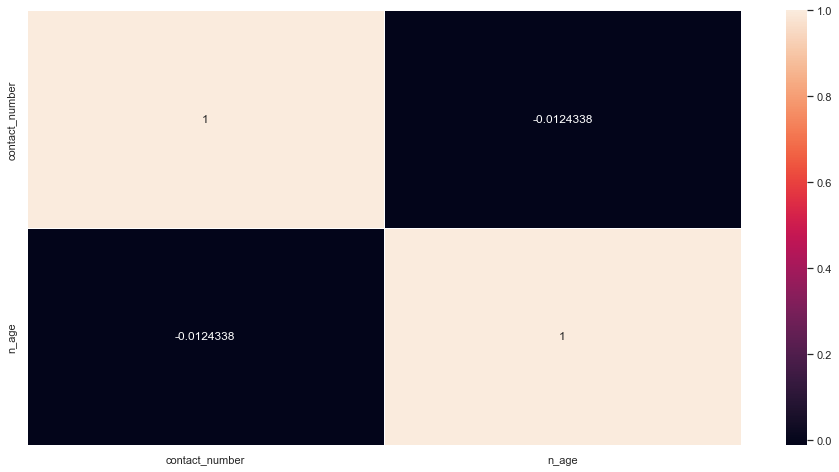

In [41]:
sns.set(font_scale=1)
f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(df_num.corr(), annot=True, linewidths=.5, ax=ax, fmt='n')
;

''

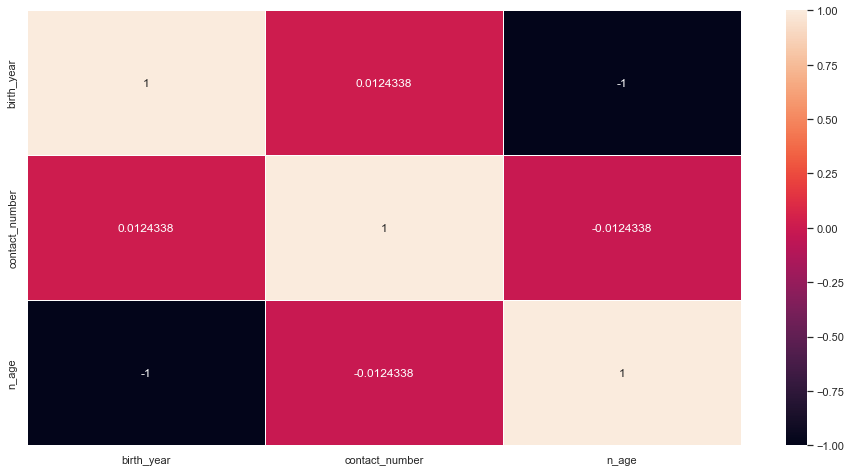

In [42]:
sns.set(font_scale=1)
f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(df.corr(), annot=True, linewidths=.5, ax=ax, fmt='n')
;

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

In [43]:
#dfb = df[['global_num',	'birth_year', 'disease'	, 'infection_order', 'contact_number' , 'n_age']]
#dfb.boxplot(figsize=(15,10))
#plt.subplots_adjust(hspace=0.5)

In [44]:
df.dtypes

sex                 object
birth_year         float64
age                 object
country             object
province            object
city                object
disease             object
infection_case      object
infection_order     object
infected_by         object
contact_number     float64
state               object
n_age              float64
dtype: object

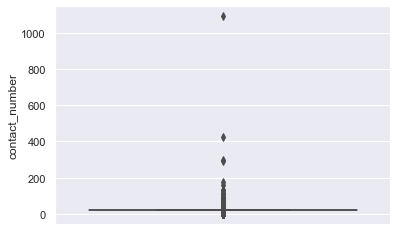

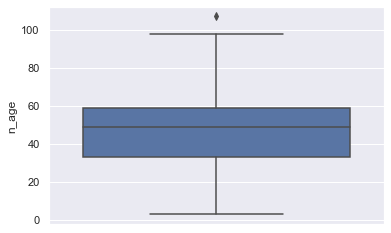

In [45]:
for feature in df_num.columns:
    sns.boxplot( y=df_num[feature] );
    plt.show()

__Comment:__
- It does appear that there are some outliers in each of the three variables.

**<font color='teal'> Create dummy features for object type features. </font>**

In [46]:
df.dtypes

sex                 object
birth_year         float64
age                 object
country             object
province            object
city                object
disease             object
infection_case      object
infection_order     object
infected_by         object
contact_number     float64
state               object
n_age              float64
dtype: object

In [47]:
df.head()

,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age
0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0.0,overseas inflow,1.0,2600788987.0,75.0,released,59.0
1,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0.0,overseas inflow,1.0,2600788987.0,31.0,released,36.0
2,male,1964.0,50s,Korea,Seoul,Jongno-gu,0.0,contact with patient,2.0,2002000001.0,17.0,released,59.0
3,male,1991.0,20s,Korea,Seoul,Mapo-gu,0.0,overseas inflow,1.0,2600788987.0,9.0,released,32.0
4,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0.0,contact with patient,2.0,1000000002.0,2.0,released,31.0


In [48]:
categorical_features = ['sex',
                        'age',
                        'country',
                        'province',
                        'city', 'infection_case', 'state']
df_dummy = pd.get_dummies(df, columns = categorical_features)
#dfdummy = pd.get_dummies(df)

In [49]:
df_dummy['disease']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2213    0.0
2214    0.0
2215    0.0
2216    0.0
2217    0.0
Name: disease, Length: 2011, dtype: object

### Split the data into test and train subsamples

In [50]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y
X = df_dummy.drop(['disease'], axis =1)
y = df_dummy['disease'].astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [51]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [52]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [53]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.998
Random Forest: f1-score=0.997


### *** QUESTION:
I'm getting an accuracy of 99%, rather than the 80% referenced to above. Do I have a bug somewhere? Can you provide a solution?

### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [54]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[401   0]
 [  1   1]]
Normalized confusion matrix
[[1.  0. ]
 [0.5 0.5]]


/var/folders/rc/20gvvbw10mg1xrcm82p5g4tm0000gn/T/ipykernel_35992/1339727859.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


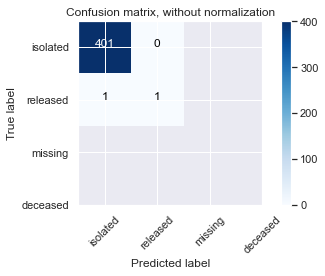

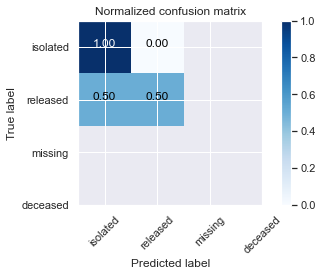

In [55]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


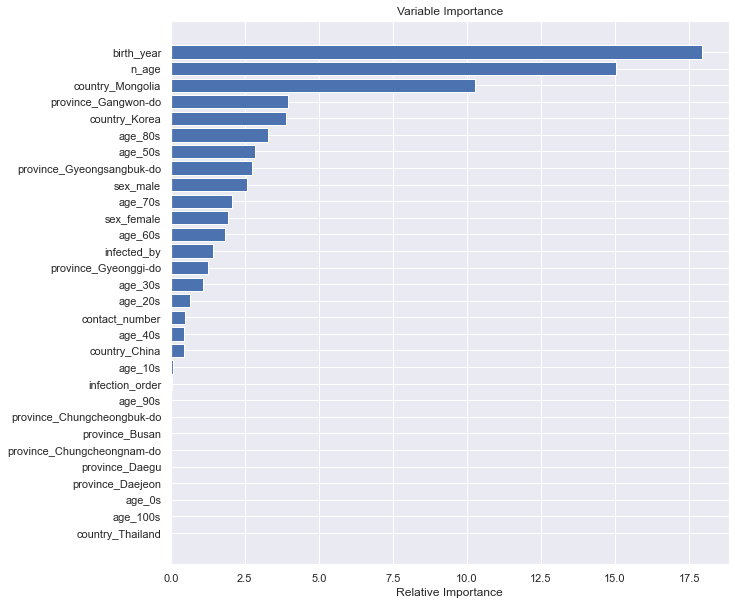

In [56]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.